# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project code solution (Dick Carrillo)
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

The solution is based on each rubric requirements.

---


## Loading libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## Loading training data provided by Udacity

In [2]:
car_images = glob.glob('training_data/vehicles/**/*.png')
noncar_images = glob.glob('training_data/non-vehicles/**/*.png')
print(len(noncar_images), len(car_images))

8968 8792


# Visualizing some training data
Here I used similar code used in the previous project (chessboard corners)

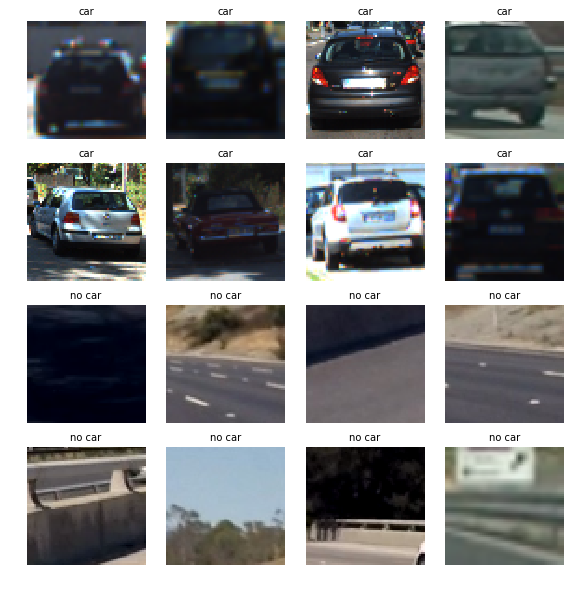

In [3]:
fig, axs = plt.subplots(4,4, figsize=(10, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list
for i in np.arange(8):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('no car', fontsize=10)
    axs[i].imshow(img)

# Histogram of Oriented Gradients (HOG)

## Defining functions used to extract HOG features
The source of this course was taken from Term_1/Lesson 20/Section 29.

In [4]:
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
import time

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_featuress(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


### visualizing some HOG image maps of Car and non car images.

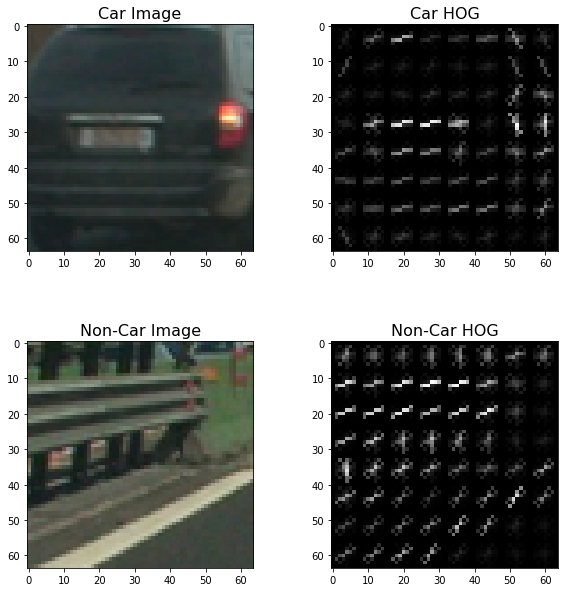

In [5]:
# Reading any image of car group
image_car = mpimg.imread(car_images[10])
# using get_hog_features() function provided by Udacity in classroom.
_, car_hog_image = get_hog_features(image_car[:,:,0], 9, 8, 8, vis=True, feature_vec=False )

# Reading any image of non car group
image_non_car = mpimg.imread(noncar_images[10])
# using get_hog_features() function provided by Udacity in classroom.
_, noncar_hog_image = get_hog_features(image_non_car[:,:,0], 9, 8, 8, vis=True, feature_vec=False)

# Visualization of original images and HUG maps.
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(image_car)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog_image, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(image_non_car)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_hog_image, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

### Extracting features of HOG maps
In this stage, I used also Udacity code provided in code. However parameter selection was done using a custome function called `tweak_function_hug_extracting_features()`. 

Extracting features using HOG is done using different color spaces, with specific orientation vectors number for each cell (with its pix_per_cell value), it is also considered a normalization in every block of subset image.

In [18]:
if True:
# Reduce the sample size because HOG features are slow to compute
    # The quiz evaluator times out after 13s of CPU time
    sample_size = 500
    cars = car_images[0:sample_size]
    notcars = noncar_images[0:sample_size]

        ### TODO: Tweak these parameters and see how the results change.
    def tweak_function_hug_extracting_features(cars, notcars, colorspace= 'HLS', orient=9, pix_per_cell = 8, cell_per_block=2, hog_channel="ALL"):
        t=time.time()
        #colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        #orient = 9
        #pix_per_cell = 8
        #cell_per_block = 2
        #hog_channel = 1 # Can be 0, 1, 2, or "ALL"
        car_features = extract_featuress(cars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
        notcar_features = extract_featuress(notcars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract HOG features...')

        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=rand_state)

        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X_train)
        # Apply the scaler to X
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)

        #print('Using:',orient,'orientations',pix_per_cell,
        #    'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        return round(svc.score(X_test, y_test), 4)
        # Check the prediction time for a single sample
        #t=time.time()
        #n_predict = 10
        #print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        #print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        #t2 = time.time()
        #print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

    # Running the feature extracting function for different values of orient and colorspaces
    # Using: 8 pixels per cell and 2 cells per block in all cases
    colorspace_options = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
    accuracy_best = 0
    for colorspace in colorspace_options:
        for orient in range(9,13):
            print('--------------------------------------------------')
            print('Color Space tested = ',colorspace)
            print('Number of orientations of HOG  = ',orient)
            accuracy_value = tweak_function_hug_extracting_features(cars, notcars, colorspace= 'HLS', orient=9, pix_per_cell = 8, cell_per_block=2, hog_channel="ALL")
            print('***************************************************')
            print('')
            if accuracy_value > accuracy_best:
                accuracy_best = accuracy_value
                color_space_best = colorspace
                orient_best = orient

    print('The best configuration of parameters was:')
    print('Color Space = ',color_space_best,'  HOG orientation = ', orient_best, '  with Accuracy = ', accuracy_best)

--------------------------------------------------
Color Space tested =  RGB
Number of orientations of HOG  =  9
17.45 Seconds to extract HOG features...
2.26 Seconds to train SVC...
Test Accuracy of SVC =  0.94
***************************************************

--------------------------------------------------
Color Space tested =  RGB
Number of orientations of HOG  =  10
16.51 Seconds to extract HOG features...
2.46 Seconds to train SVC...
Test Accuracy of SVC =  0.95
***************************************************

--------------------------------------------------
Color Space tested =  RGB
Number of orientations of HOG  =  11
16.55 Seconds to extract HOG features...
1.84 Seconds to train SVC...
Test Accuracy of SVC =  0.965
***************************************************

--------------------------------------------------
Color Space tested =  RGB
Number of orientations of HOG  =  12
16.95 Seconds to extract HOG features...
2.8 Seconds to train SVC...
Test Accuracy of SV

### Best HOG configuration parameters 
The best configuration of parameters was:
`Color Space =  HLS   HOG orientation =  10   with Accuracy =  0.98. Using: 8 pixels per cell and 2 cells per block in all cases`

# Sliding Window Search


(720, 1280, 3)
126


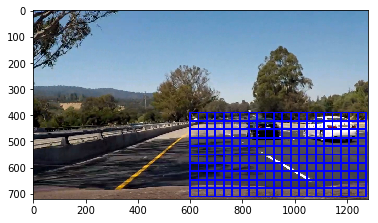

In [7]:
#image = mpimg.imread('./video_lab/bbox-example-image.jpg')
image = mpimg.imread('./video_lab/frame22.jpg')
print(image.shape)

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[600, None], y_start_stop=[390, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
print(len(windows))

In [45]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
#from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
#images = glob.glob('*.jpeg')
#cars = []
#notcars = []
#for image in images:
#    if 'image' in image or 'extra' in image:
#        notcars.append(image)
#    else:
#        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
print(len(car_images))
sample_size =6000
cars = car_images[6000:sample_size+1600]
notcars = noncar_images[6000:sample_size+1600]
#cars = car_images
#notcars = noncar_images

8792


In [46]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (50, 50) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [390, None] # Min and max in y to search in slide_window()
                        
if False:
    car_features = extract_featuress(cars, cspace=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)

    notcar_features = extract_featuress(notcars, cspace=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
if True:
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


MemoryError: 

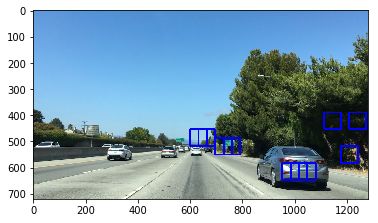

In [44]:

image = mpimg.imread('./video_lab/bbox-example-image.jpg')
#image = mpimg.imread('./video_lab/frame22.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[600, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


